# About

![prjpic](doc/media_main/story.png)

This is the main demo of this repo, it is about a concept study on the MIMII dataset to detect anomalies of machines or machine parts like fans, slider, pump and valves by means of classic machine learning and deep learning methods.

In runs through the essentials to demonstrate the steps
* feature extraction
* indvitual model training 
* ensamble building and varfication
* summery and scores

# Imports

In [1]:
#===============================================
# Basic Imports
BASE_FOLDER = './'
TARGET_FOLDER_FE = r'\dataset\extdia_v1_essential' # output folder for ffeat. extraction
# import the repo-local utility py files
%run -i utility\feature_extractor\JupyterLoad_feature_extractor.py
%run -i utility\modeling\JupyterLoad_modeling.py

# feature extraction diagram
%run -i feature_extraction_diagrams\extdia_v1_essential
%run -i utility\extractor_batch.py

# helper
from tqdm.auto import tqdm
import glob
import gc

# sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA

feat_ext_folder = os.path.abspath(BASE_FOLDER + TARGET_FOLDER_FE)

load feature_extractor_mother
load feature_extractor_mel_spectra
load feature_extractor_psd
load feature_extractor_ICA2
load feature_extractore_pre_nnFilterDenoise
load extractor_diagram_mother
load Simple_FIR_HP
load TimeSliceAppendActivation
load load_data
Load split_data
Load anomaly_detection_models
Load pseudo_supervised_models
Load tensorflow models
Load detection_pipe
load # extractor diagram V1 essential
load extractor_batch


## General config

To customize the following notebook execution, set the specifications here:

The execution time on a local desktop PC for all four IDs of one machine and one SNR is circa 1 hour. We recommend only executing a set of 4 variations at a time.

In [29]:
#===============================================
# Possible variations
# 
# SNRs = ['6dB', '0dB', 'min6dB']
# machines = ['pump', 'valve', 'fan', 'slider']
# IDs = ['00', '02', '04', '06']

SNRs = ['6dB']
machines = ['valve']
IDs = ['00']

# note: increase n_jobs to max. CPUs you have use all hyperthreading cores (there is no auto detect just now)
n_jobs = 8

## Utility wrapper functions

In [30]:
def feat_ext_process_set(FileFindDict, main_channel=0, sporadic=False, augment=False,FileCountLimit=None, n_jobs=4):
    
    if sporadic:
        dt = 1 # 1 means time slicing 
    else:
        dt = 0
        
    if augment:
        ag = 0 # augment only normal operation
    else:
        ag = -2 # not existing class = no augment
        
    extractor_batch(base_folder= BASE_FOLDER, 
                    target_folder=TARGET_FOLDER_FE, 
                    extdia = extdia_v1_essential, 
                    FileFindDict = FileFindDict,
                    n_jobs = n_jobs,
                    target_class_map = {'abnormal':1, 'normal': 0},
                    FileCountLimit = FileCountLimit,
                    datset_folder_from_base = 'dataset',
                    fHP=120,
                    DeviceType=dt,
                    main_channel = main_channel,
                    augment=ag)
    
    gc.collect()

In [31]:
def find_data_file(SNR, machine, ID):
    '''
    function to find existing feature data files
    '''
    path = glob.glob(BASE_FOLDER 
              + '/dataset/extdia_v1_essential/{}{}{}_EDiaV1HP'.format(machine, SNR, ID) 
              + "*pandaDisc*.pkl", recursive=True)
    
    if len(path) == 0:
        return None
    elif len(path) == 1:
        return path[0]
    else:
        raise Exception('More than one file found:', path)

# Feat Extraction

## Confirm feature extraction diagram

![exdia](doc/media_feature_extraction/exdia_v1_essential.png)
in order to modify the diagram go the class definition:  /feature_extraction_diagrams/extdia_v1_essential.py

### Note to the main_channel
The main channel is picking one microphone out of the 8, 
this can be seen as if the demo version is strictly in working mono
Or a DOA could be used to find the main direction see : feature_extraction_diagrams/A21_DirectionOfArrival_DOA/pyroomacustic_DOA.ipynb

if not find_data_file('6dB', 'pump', '02'):
    ExampleFileFilter = {'SNR': ['6dB'],'machine': ['pump'],'ID': ['02']}
    # create some 
    feat_ext_process_set(ExampleFileFilter,
                        main_channel=2,
                        sporadic = False,
                        augment = True,
                        FileCountLimit= 4,
                        n_jobs=n_jobs)

## Spot Check the output

# This code reloads pkl files that have been stored
# in the step above - notice only created files can be loaded
# then a plot is made form n and n+1 output ports
# this cell is ment as a spot check before running the batch that might,
# take much more time !

d_MEL_den = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpMEL_den.pkl', "rb" ))
d_MEL_raw = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpMEL_raw.pkl', "rb" ))
d_PSD_raw = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpPSD_raw.pkl', "rb" ))
n1=2
n2=7
plt.figure(figsize=(16,9))
plt.subplot(321)
feature_extractor_from_dict(d_MEL_raw[n1],BASE_FOLDER).plot(False)
plt.subplot(322)
feature_extractor_from_dict(d_MEL_raw[n2],BASE_FOLDER).plot(False)
plt.subplot(323)
feature_extractor_from_dict(d_MEL_den[n1],BASE_FOLDER).plot(False)
plt.subplot(324)
feature_extractor_from_dict(d_MEL_den[n2],BASE_FOLDER).plot(False)
plt.subplot(325)
feature_extractor_from_dict(d_PSD_raw[n1],BASE_FOLDER).plot(True)
plt.subplot(326)
feature_extractor_from_dict(d_PSD_raw[n2],BASE_FOLDER).plot(True)
plt.tight_layout()


## Batch creation of feature data

In [ ]:
# Create the batch of feature data
# note: there is still a deepcopy issue you may expirence memory leak : https://github.com/BA-HanseML/NF_Prj_MIMII_Dataset/issues/58
for SNR in SNRs:
    for machine in machines:
        for ID in IDs:
            # check if files already exist
            if not find_data_file(SNR, machine, ID):
                BatchFileFilter = {'SNR': SNR,'machine': machine,'ID': ID}
                feat_ext_process_set(BatchFileFilter,
                                    main_channel=2,
                                    sporadic = False,
                                    augment = True,
                                    n_jobs=n_jobs)

2020-05-22 15:05:45: Target folder will be: D:\Capstone\NF_Prj_MIMII_Dataset\dataset\extdia_v1_essential
2020-05-22 15:05:45: Extractor diagram is fof type: <class '__main__.extdia_v1_essential'>
2020-05-22 15:05:45: --------------------------------------------
2020-05-22 15:05:45: Working on machinepart:valve SNR:6dB ID:00
2020-05-22 15:05:45: Files to process: 1110
2020-05-22 15:05:45: multithread mode filling the queue


# Modeling

# PSD_raw_flat_6dB_pump_ID00_SVM

def find_pipe(feature, SNR, machine, ID, model):
    '''
    function to find existing model pipe files
    '''
    path = glob.glob(BASE_FOLDER 
              + '/pipes/{}_*_{}_{}_ID{}_{}_*.pkl'.format(feature, SNR, machine, ID, model), recursive=True)
    
    if len(path) == 0:
        return None
    elif len(path) == 1:
        return path[0]
    else:
        raise Exception('More than one file found:', path)

In [14]:
class uni_Ensemble(object):
    def __init__(self, SNR, machine, ID):
        self.SNR = SNR
        self.machine = machine
        self.ID = ID
        
        self.weights = [0.9, 0.8]
        
        self.tasks = [{
                    'path_descr': find_data_file(SNR, machine, ID),
                    'feat':feature[1], 
                    'feat_col':feature[0], 
                    'SNR':SNR, 
                    'machine':machine,
                    'ID':ID,
                    'BASE_FOLDER':BASE_FOLDER
        } for feature in [
                         ('PSD_raw', {'function':'flat'}), # Isolation Forest Welch method
                         ('PSD_raw', {'function':'flat'})]] # SVM augmented Welch method
        
        self.pipes = [
            Pipe(preprocessing_steps=[(StandardScaler, {})], 
                 modeling_step=(uni_IsolationForest, {'n_estimators':200, 'max_features':1}),
                 pseudo_sup=False), # Isolation Forest Welch method
            
            Pipe(preprocessing_steps=[(StandardScaler, {})], 
                 modeling_step=(uni_svm, {'C': 0.1, 'degree':3,'kernel':'rbf'}),
                 pseudo_sup=True), # SVM augmented Welch method
        ]
        
    def fit(self):
        for pipe, task in zip(self.pipes, self.tasks):
            
            # set up the task
            pipe.task = task
            
            # split data into train and testset
            pipe.split_data()
            
            # get the data
            print('...loading data')
            data_train, data_test = pipe.get_data()
            print('data loading completed\n\n...preprocessing data')

            # preprocessing
            data_train, data_test = pipe.preprocess(data_train, data_test)
            print('data preprocessing finished\n\n...fitting the model')

            # fitting the model
            pipe.fit_model(data_train)
            print('model fitted successfully\n\n...fitting the prediction scaler')

            # fitting the prediction scaler
            pipe.fit_aggr_score_scaler(data_train, pipe.df_train.path)
            print('prediction scaler fitted successfully\n\n...evaluating model')
            
    def predict(self, data, files):
        pass
    
    def evaluate(self):
        for i, (pipe, weight) in enumerate(zip(self.pipes, self.weights)):
            _, data_test = pipe.get_data()
            data_test = pipe.preprocess_post(data_test)
            gt_ = pipe.df_test.abnormal.replace(to_replace=1, value=-1).replace(to_replace=0, value=1)
            if i == 0:
                predictions = pipe.predict_aggr_score(data_test, pipe.df_test.path)*weight
                ground_truth = pipe.median_by_file(gt_, pipe.df_test.path)
            else:
                predictions = np.append(predictions, pipe.predict_aggr_score(data_test, pipe.df_test.path)*weight, axis=1)
                if not ground_truth.equals(pipe.median_by_file(gt_, pipe.df_test.path)):
                    print('Something went wrong with testset')
            
        prediction = np.sum(predictions, axis=1)
        
        return roc_auc_score(ground_truth, prediction)

In [27]:
ensemble = uni_Ensemble('6dB', 'valve', '00')

In [28]:
ensemble.fit()

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [17]:
ensemble.evaluate()

0.44373808010171645

In [18]:
ensemble.pipes[0].ground_truth

0     -1.0
1     -1.0
2     -1.0
3     -1.0
4     -1.0
      ... 
281    1.0
282    1.0
283    1.0
284    1.0
285    1.0
Name: abnormal, Length: 286, dtype: float64

In [19]:
ensemble.pipes[1].ground_truth

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
281    0.0
282    0.0
283    0.0
284    0.0
285    0.0
Name: abnormal, Length: 286, dtype: float64

In [22]:
data_train, data_test = ensemble.pipes[1].get_data()
ensemble.pipes[1].evaluate(data_test)

(array([  8.,   6.,  12.,  20.,  15.,  23., 199.,   1.,   1.,   1.]),
 array([0.69830556, 0.69830794, 0.69831032, 0.6983127 , 0.69831508,
        0.69831746, 0.69831984, 0.69832222, 0.6983246 , 0.69832699,
        0.69832937]),
 <a list of 10 Patch objects>)

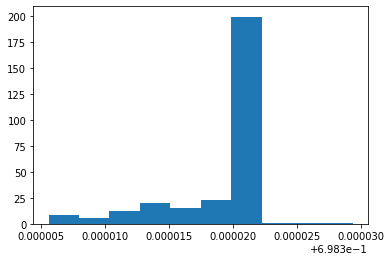

In [25]:
plt.hist(ensemble.pipes[1].df_test.pred_scores)

In [26]:
ensemble.pipes[1].roc_auc

0.2254388967675681

In [ ]:
#===============================================
# Adding up all the tasks
tasks = []
pipes = []

In [ ]:
with open('./pipes/MEL_den_frame5_6dB_pump_ID00_IsoFor_64est_4mf_20200520_160147.pkl', 'rb') as f:
    pipe = pickle.load(f)

In [ ]:
data_train, data_test = pipe.get_data()

# preprocessing
data_train, data_test = pipe.preprocess(data_train, data_test)

In [ ]:
pipe.fit_aggr_score_scaler(data_train, pipe.df_train.path)

In [ ]:
y_pred = pipe.predict_aggr_score(data_test, pipe.df_test.path)

In [ ]:
y_true = pipe.median_by_file(pipe.ground_truth, pipe.df_test.path)

In [ ]:
roc_auc_score(y_true, y_pred)

# Define Training Task list for the pipe
features = [('MEL_den', {'function':'frame', 'frames':5})]
model = 'IsoFor'

# Preprocessing pipe
preprocessing = [
    (PCA, {'n_components':64}),
    (StandardScaler, {})
]

# uni_Model define
# See also \utility\modeling\pseudo_supervised_models.py form more uni models 
modeling = (uni_AutoEncoder, {'epochs':50})

for machine in machines:
    for SNR in SNRs:
        for ID in IDs:
            for feature in features:
                task = {
                'path_descr': find_data_file(SNR, machine, ID),
                'feat':feature[1], 
                'feat_col':feature[0], 
                'SNR':SNR, 
                'machine':machine,
                'ID':ID,
                'BASE_FOLDER':BASE_FOLDER}

                # append tasks
                tasks.append(task)

                # append pipes
                pipes.append(Pipe(preprocessing, modeling, pseudo_sup=False))

### Isolation Forest on spectral data

# Define Training Task list for the pipe
features = [('MEL_den', {'function':'frame', 'frames':5})]
model = 'IsoFor'

# Preprocessing pipe
preprocessing = [
    (PCA, {'n_components':64}),
    (StandardScaler, {})
]

# uni_Model define
# See also \utility\modeling\pseudo_supervised_models.py form more uni models 
modeling = (uni_IsolationForest, {'n_estimators':64, 'max_features':4})

for machine in machines:
    for SNR in SNRs:
        for ID in IDs:
            for feature in features:
                task = {
                'path_descr': find_data_file(SNR, machine, ID),
                'feat':feature[1], 
                'feat_col':feature[0], 
                'SNR':SNR, 
                'machine':machine,
                'ID':ID,
                'BASE_FOLDER':BASE_FOLDER}

                # append tasks
                tasks.append(task)

                # append pipes
                pipes.append(Pipe(preprocessing, modeling, pseudo_sup=False))

### Isolation Forest on welch spectrum

In [ ]:
# Define Training Task list for the pipe
features = [('PSD_raw', {'function':'channel'})]
model = 'IsoFor'

# Preprocessing pipe
preprocessing = [
    (StandardScaler, {})
]

# uni_Model define
# See also \utility\modeling\pseudo_supervised_models.py form more uni models 
modeling = (uni_IsolationForest, {'n_estimators':200, 'max_features':1})

for machine in machines:
    for SNR in SNRs:
        for ID in IDs:
            for feature in features:
                task = {
                'path_descr': find_data_file(SNR, machine, ID),
                'feat':feature[1], 
                'feat_col':feature[0], 
                'SNR':SNR, 
                'machine':machine,
                'ID':ID,
                'BASE_FOLDER':BASE_FOLDER}

                # append tasks
                tasks.append(task)

                # append pipes
                pipes.append(Pipe(preprocessing, modeling, pseudo_sup=False))

## Setting up pseudo supervised training

# Define Training Task list for the pipe

features = [('PSD_raw', {'function':'flat'})]
model = 'SVM'

# Preprocessing pipe
preprocessing = [
    (StandardScaler, {})
]

# uni_Model define
# See also \utility\modeling\pseudo_supervised_models.py form more uni models 
# also on how to use grid search (here not needed yet hence no augmentation feedback)
modeling = (uni_svm, {'C': 0.1, 'degree':3,'kernel':'rbf'})


for machine in machines:
    for SNR in SNRs:
        for ID in IDs:
            for feature in features:
                # check if model already exists
                if not find_pipe(feature[0], SNR, machine, ID, model):
                    task = {
                    'path_descr': find_data_file(SNR, machine, ID),
                    'feat':feature[1], 
                    'feat_col':feature[0], 
                    'SNR':SNR, 
                    'machine':machine,
                    'ID':ID,
                    'BASE_FOLDER':BASE_FOLDER}
                    
                    # append tasks
                    tasks.append(task)
                    
                    # append pipes
                    pipes.append(Pipe(preprocessing, modeling, pseudo_sup=True))

## Training the models

In [ ]:
pipes[0].run_pipe(task)

In [ ]:
tasks_failed = []
for pipe, task in tqdm(zip(pipes, tasks), total=len(tasks)):
    try:
        pipe.run_pipe(task)
    except:
        tasks_failed.append(task)
        print('Task failed \n', task)

# Ensemble Blending

# Summery/ Results